In [1]:
import itertools
import os
os.chdir(os.pardir)
import time

import jax
import jax.numpy as jnp
import jax.nn as nn
from jax import random, vmap, jit, grad
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy.random as npr
from scipy.special import roots_legendre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import trange

from pycbem.utils.dataloader import load_sphere_coords

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
data = load_sphere_coords(2312)
data.head()

,x,y,z
0,-0.049703,-0.051179,0.050094
1,0.049703,-0.051179,-0.050094
2,-0.050094,-0.051179,-0.049703
3,0.050094,-0.051179,0.049703
4,-0.049653,0.053037,0.048751


In [4]:
target_area = (2 / 100, 2 / 100)
target_area_origin = (-target_area[0]/2, -target_area[1]/2)
data_target = data[
    (data['y'] < 0) &
    (data['x'] > target_area_origin[0]) &
    (data['x'] < target_area_origin[0] * -1) &
    (data['z'] > target_area_origin[1]) &
    (data['z'] < target_area_origin[1] * -1)]
data_target.reset_index(drop=True, inplace=True)
data_target.head()

,x,y,z
0,-0.009562,-0.088281,0.009294
1,0.009562,-0.088281,-0.009294
2,0.009294,-0.088281,0.009562
3,-0.009294,-0.088281,-0.009562
4,-0.008688,-0.088457,0.008554


In [5]:
X = data_target[['x', 'z']].to_numpy()
y = data_target['y'].to_numpy()

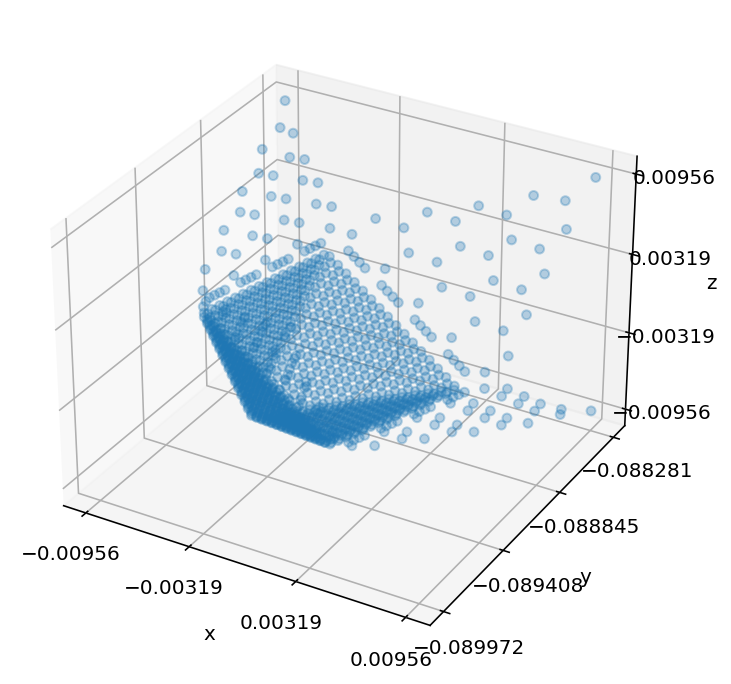

In [6]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y, X[:, 1], alpha=0.3)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[X[:, 0].min():X[:, 0].max():4j], 
       yticks=jnp.mgrid[y.min():y.max():4j],
       zticks=jnp.mgrid[X[:, 1].min():X[:, 1].max():4j]);

In [7]:
def cart2sph(x, y, z):
    r = jnp.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = jnp.arccos(z / r)
    phi = jnp.arctan2(y, x)
    return (r, theta, phi)


def sph2cart(r, theta, phi):
    x = r * jnp.cos(phi) * jnp.sin(theta)
    y = r * jnp.sin(phi) * jnp.sin(theta)
    z = r * jnp.cos(theta)
    return (x, y, z)

In [8]:
_, theta, phi = cart2sph(X[:, 0], y, X[:, 1])
theta_a = theta.min()
theta_b = theta.max()
phi_a = phi.min()
phi_b = phi.max()
theta_points, theta_weights = roots_legendre(100)
phi_points, phi_weights = roots_legendre(100)
theta_points = 0.5 * (theta_points + 1.) * (theta_b - theta_a) + theta_a
theta_weights = 0.5 * theta_weights * (theta_b - theta_a)
phi_points = 0.5 * (phi_points + 1.) * (phi_b - phi_a) + phi_a
phi_weights = 0.5 * phi_weights * (phi_b - phi_a)

r = 0.09
phi_grid, theta_grid = jnp.meshgrid(phi_points, theta_points)
xt, yt, zt = sph2cart(r, theta_grid.ravel(), phi_grid.ravel())

In [9]:
X = jnp.hstack((xt.reshape(-1, 1), zt.reshape(-1, 1)))
y = jnp.array(yt).reshape(-1, 1)

In [10]:
X = X * 100
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled)

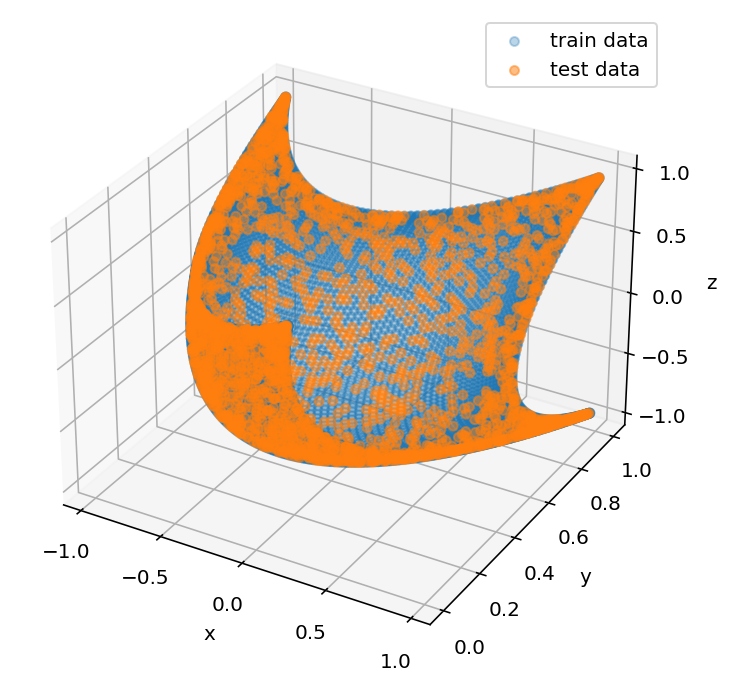

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X_train[:, 0], y_train, X_train[:, 1], c='C0', label='train data', alpha=0.3)
ax.scatter(X_test[:, 0], y_test, X_test[:, 1], c='C1', label='test data', alpha=0.5)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[-1:1:5j], zticks=jnp.mgrid[-1:1:5j])
ax.legend();

In [18]:
rng = random.PRNGKey(0)

In [19]:
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    def random_layer_params(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return (scale * random.normal(w_key, (n, m)),
                scale * random.normal(b_key, (n, )))
    return [random_layer_params(m, n, key)
            for m, n, key in zip(sizes[:-1], sizes[1:], keys)]

In [20]:
def forward(params, X):
    output = X
    for w, b in params[:-1]:
        output = nn.relu(w @ output + b)
    w, b = params[-1]
    output = w @ output + b
    return output

In [21]:
batch_forward = vmap(forward, in_axes=(None, 0))

In [22]:
@jit
def loss_fn(params, batch):
    X, y = batch
    y_pred = batch_forward(params, X)
    return jnp.sum(jnp.square(y_pred - y))

In [23]:
grad_fn = jit(grad(loss_fn))

In [24]:
@jit
def update(step, optim_state, batch):
    params = optim_params(optim_state)
    grads = grad_fn(params, batch)
    optim_state = optim_update(step, grads, optim_state)
    return optim_state

In [25]:
def data_stream(num_train, num_batches):
    rng = npr.RandomState(0)
    while True:
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield X_train[batch_idx], y_train[batch_idx]

In [30]:
step_size = 0.001
n_epochs = 500
printout = int(n_epochs / 10.)
batch_size = 128
# momentum_mass = 0.9  # for momentum and adagrad
sizes = [2, 30, 60, 30, 1]

num_train = X_train.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

batches = data_stream(num_train, num_batches)

optim_init, optim_update, optim_params = optimizers.adam(step_size)
init_params = init_network_params(sizes, rng)
optim_state = optim_init(init_params)
itercount = itertools.count()

In [31]:
loss_train, loss_test = [], []
for epoch in trange(n_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        optim_state = update(next(itercount), optim_state, next(batches))
    epoch_time = time.time() - start_time
    
    params = optim_params(optim_state)
    if (epoch == 0) or (epoch % printout == (printout - 1)):
        if epoch == 0:
            print('epoch \t| loss on test set')
            print('----- \t| ----------------')
        loss_train.append(loss_fn(params, (X_train, y_train)))
        l = loss_fn(params, (X_test, y_test))
        loss_test.append(l)
        print(f'{epoch + 1} \t| {l}')

  0%|          | 0/500 [00:00<?, ?it/s]

epoch 	| loss on test set
----- 	| ----------------
1 	| 181.08013916015625
50 	| 0.05379112437367439
100 	| 0.03264698386192322
150 	| 0.021126756444573402
200 	| 0.026329385116696358
250 	| 0.027577444911003113
300 	| 0.015872851014137268
350 	| 0.024607738479971886
400 	| 0.02053271047770977
450 	| 0.018453069031238556
500 	| 0.01619420014321804


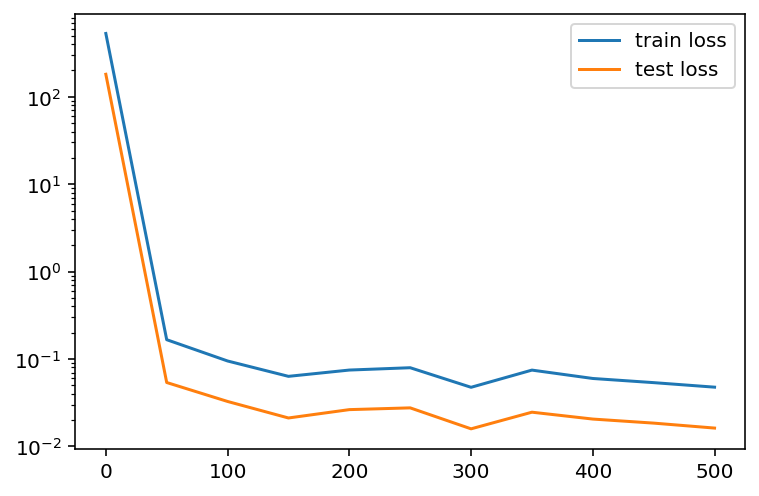

In [32]:
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_train, label='train loss')
plt.plot(jnp.arange(0, n_epochs+1, printout), loss_test, label='test loss')
plt.yscale('log')
plt.legend();

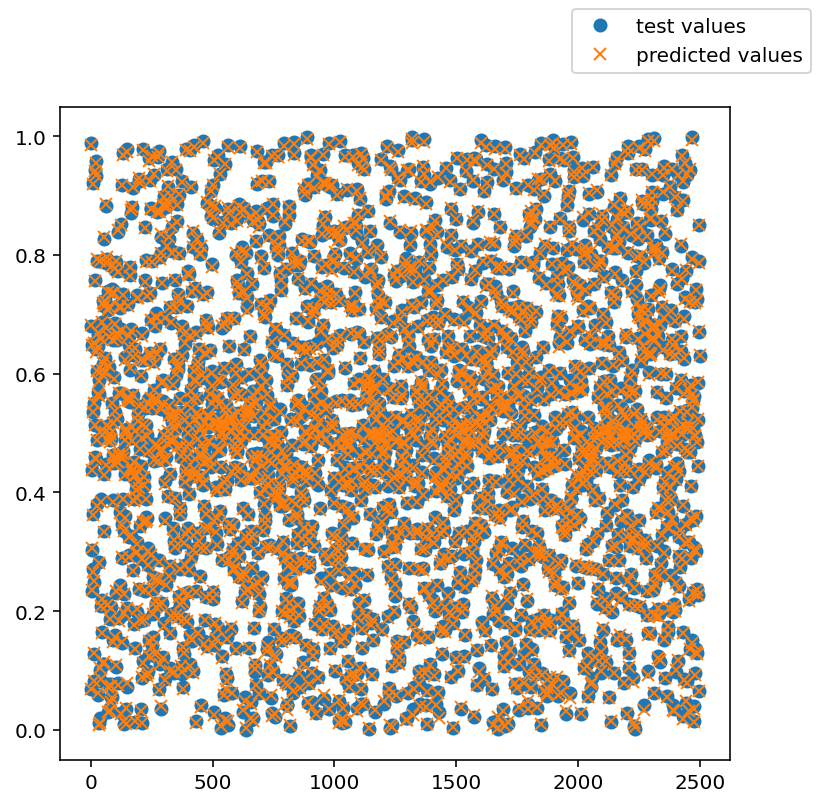

In [33]:
fig = plt.figure(figsize=(6, 6))
plt.plot(y_test.flatten(), 'o', label='test values')
plt.plot(batch_forward(params, X_test).flatten(), 'x', label='predicted values')
fig.legend();

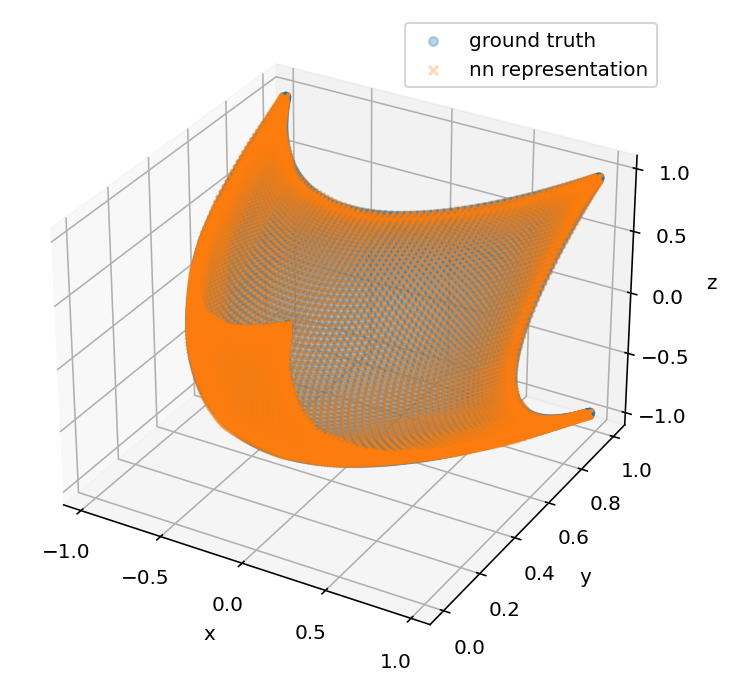

In [34]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(X[:, 0], y_scaled, X[:, 1], alpha=0.3, label='ground truth')
ax.scatter(X[:, 0], batch_forward(params, X), X[:, 1], marker='x', alpha=0.3, label='nn representation')
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xticks=jnp.mgrid[-1:1:5j], zticks=jnp.mgrid[-1:1:5j])
ax.legend();